# 1. Seq2Seq 模型简介

## 1.1 简介

Sequence-to-sequence (seq2seq) 模型，顾名思义，其输入是一个序列，输出也是一个序列，例如输入是英文句子，输出则是翻译的中文。seq2seq 可以用在很多方面：机器翻译、QA 系统、文档摘要生成、Image Captioning (图片描述生成器)。

## 1.2 基本框架

第一种结构

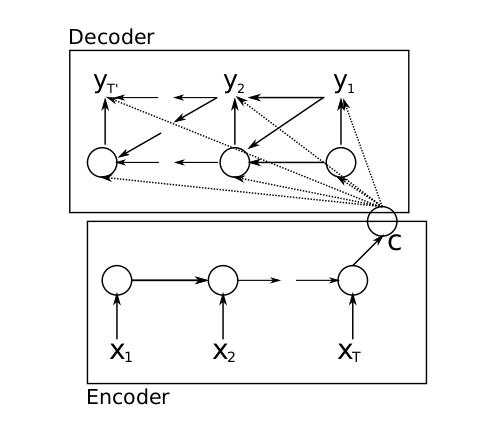

论文中提出的 seq2seq 模型可简单理解为由三部分组成：Encoder、Decoder 和连接两者的 State Vector (中间状态向量) C 。

上图中 Encoder 和 Decoder 可以是一个 RNN ，但通常是其变种 LSTM 或者 GRU 。Encoder 和 Decoder 具体介绍请见第三部分。

第二种结构

该结构是最简单的结构，和第一种结构相似，只是 Decoder 的第一个时刻只用到了 Encoder 最后输出的中间状态变量 ：

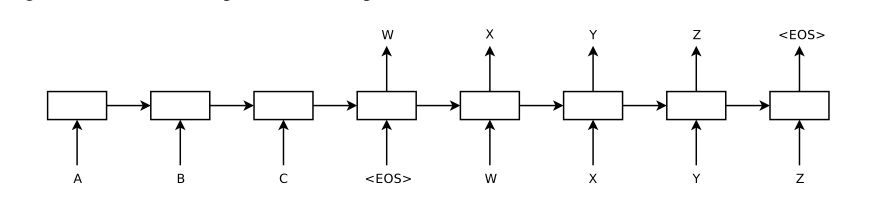

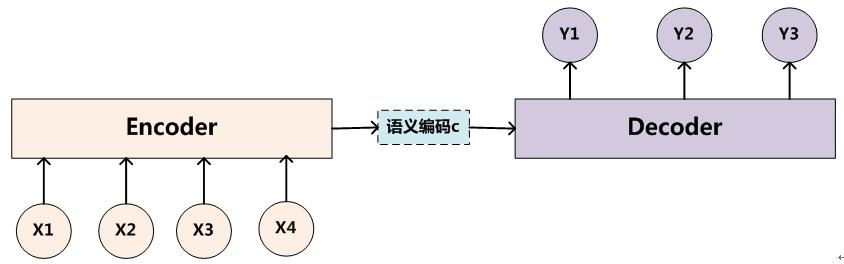

Encoder-Decoder 模型是深度学习中常见的一种模型。在本文中，我们只简单介绍其在文本-文本的应用，比如将英语翻译成汉语，所以该模型也可以称为 Seq2Seq 模型

# 2. Seq2Seq模型细节

## 2.1编码器

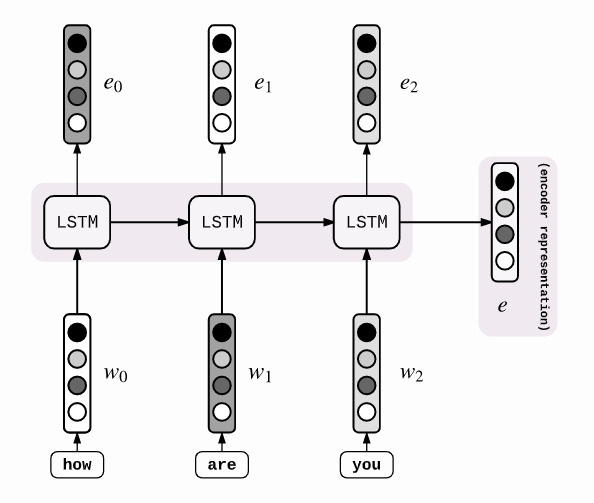

我们的输入序列是"how are you"，输入序列中的每个单词都与一个向量$w \in \mathbb { R } ^ { d }$相关联（通过查找表）。在我们的例子中，我们有3个单词，因此我们的输入将被转换为$\left[ w _ { 0 } , w _ { 1 } , w _ { 2 } \right] \in \mathbb { R } ^ { d \times 3 }$.然后，我们在这个向量序列上运行LSTM并存储由LSTM输出的最后一个隐藏状态：这将是我们的编码器表示e(即$e _ { 2 }$).

## 2.2解码器

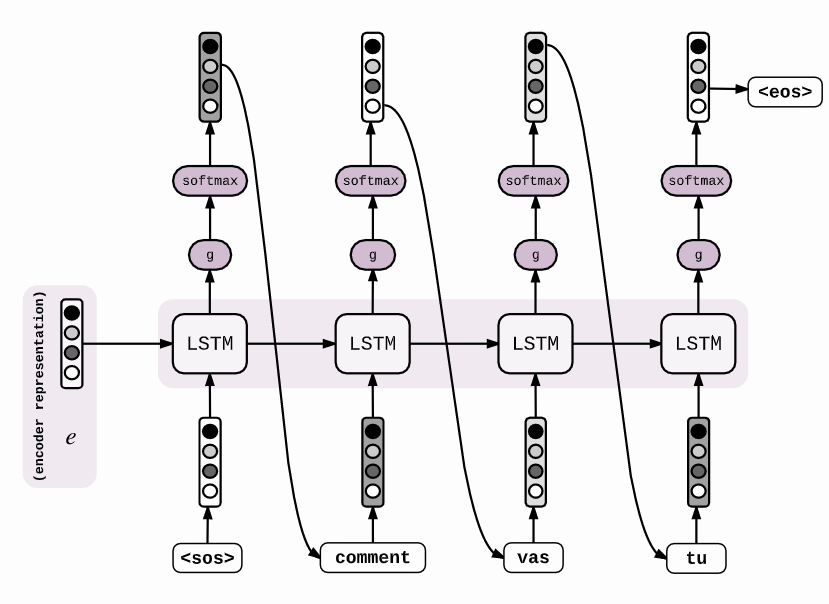

现在我们有了一个向量e，用于捕获输入序列的含义，我们将用它来逐字生成目标序列。另一个LSTM的输入为隐藏状态e和句子开始符向量$w _ { s o s }$，
 它输出一个隐藏状态$h _ { 0 } \in \mathbb { R } ^ { h }$，然后我们应用函数$g : \mathbb { R } ^ { h } \mapsto \mathbb { R } ^ { V }$因此$s _ { 0 } : = g \left( h _ { 0 } \right) \in \mathbb { R } ^ { V }$ 是一个与词汇大小相同的向量。

\begin{aligned} h _ { 0 } & = \operatorname { LSTM } \left( e , w _ { s o s } \right) \\ s _ { 0 } & = g \left( h _ { 0 } \right) \\ p _ { 0 } & = \operatorname { softmax } \left( s _ { 0 } \right) \\ i _ { 0 } & = \operatorname { argmax } \left( p _ { 0 } \right) \end{aligned}

然后，用softmax将$s _ { 0 }$标准化为概率向量$p _ { 0 } \in \mathbb { R } ^ { V }$. 现在$p _ { 0 }$的每项内容将反映词汇表中每个单词出现的概率。比如“我”这个词的概率最高（因此$i _ { 0 } = \operatorname { argmax } \left( p _ { 0 } \right)$对应于“我”的索引）。这样获取相应的向量
$w _ { i _ { 0 } } = w _ { c o m m e n t }$并重复该过程：LSTM将把$h _ { 0 }$作为隐藏层的状态，把$w _ { \text { comment } }$作为输入，接着会输出第二个单词的概率向量$p _ { 1 }$.


当预测的单词是句子标记的特殊结尾时，解码停止。

## 2.3 Teacher Force 策略
在基础的模型中，Decoder的每一次解码又会作为下一次解码的输入，这样就会导致一个问题就是错误累计，如果其中一个RNN单元解码出现误差了，那么这个误差就会传递到下一个RNN单元，使训练结果误差越来越大。Teacher Forcing在一定程度上解决了这个问题，它帮助模型加速收敛,它的流程如下图所示，**在训练过程中，使用要解码的序列作为输入进行训练**.在inference阶段不能使用，因为不知道要预测的序列。

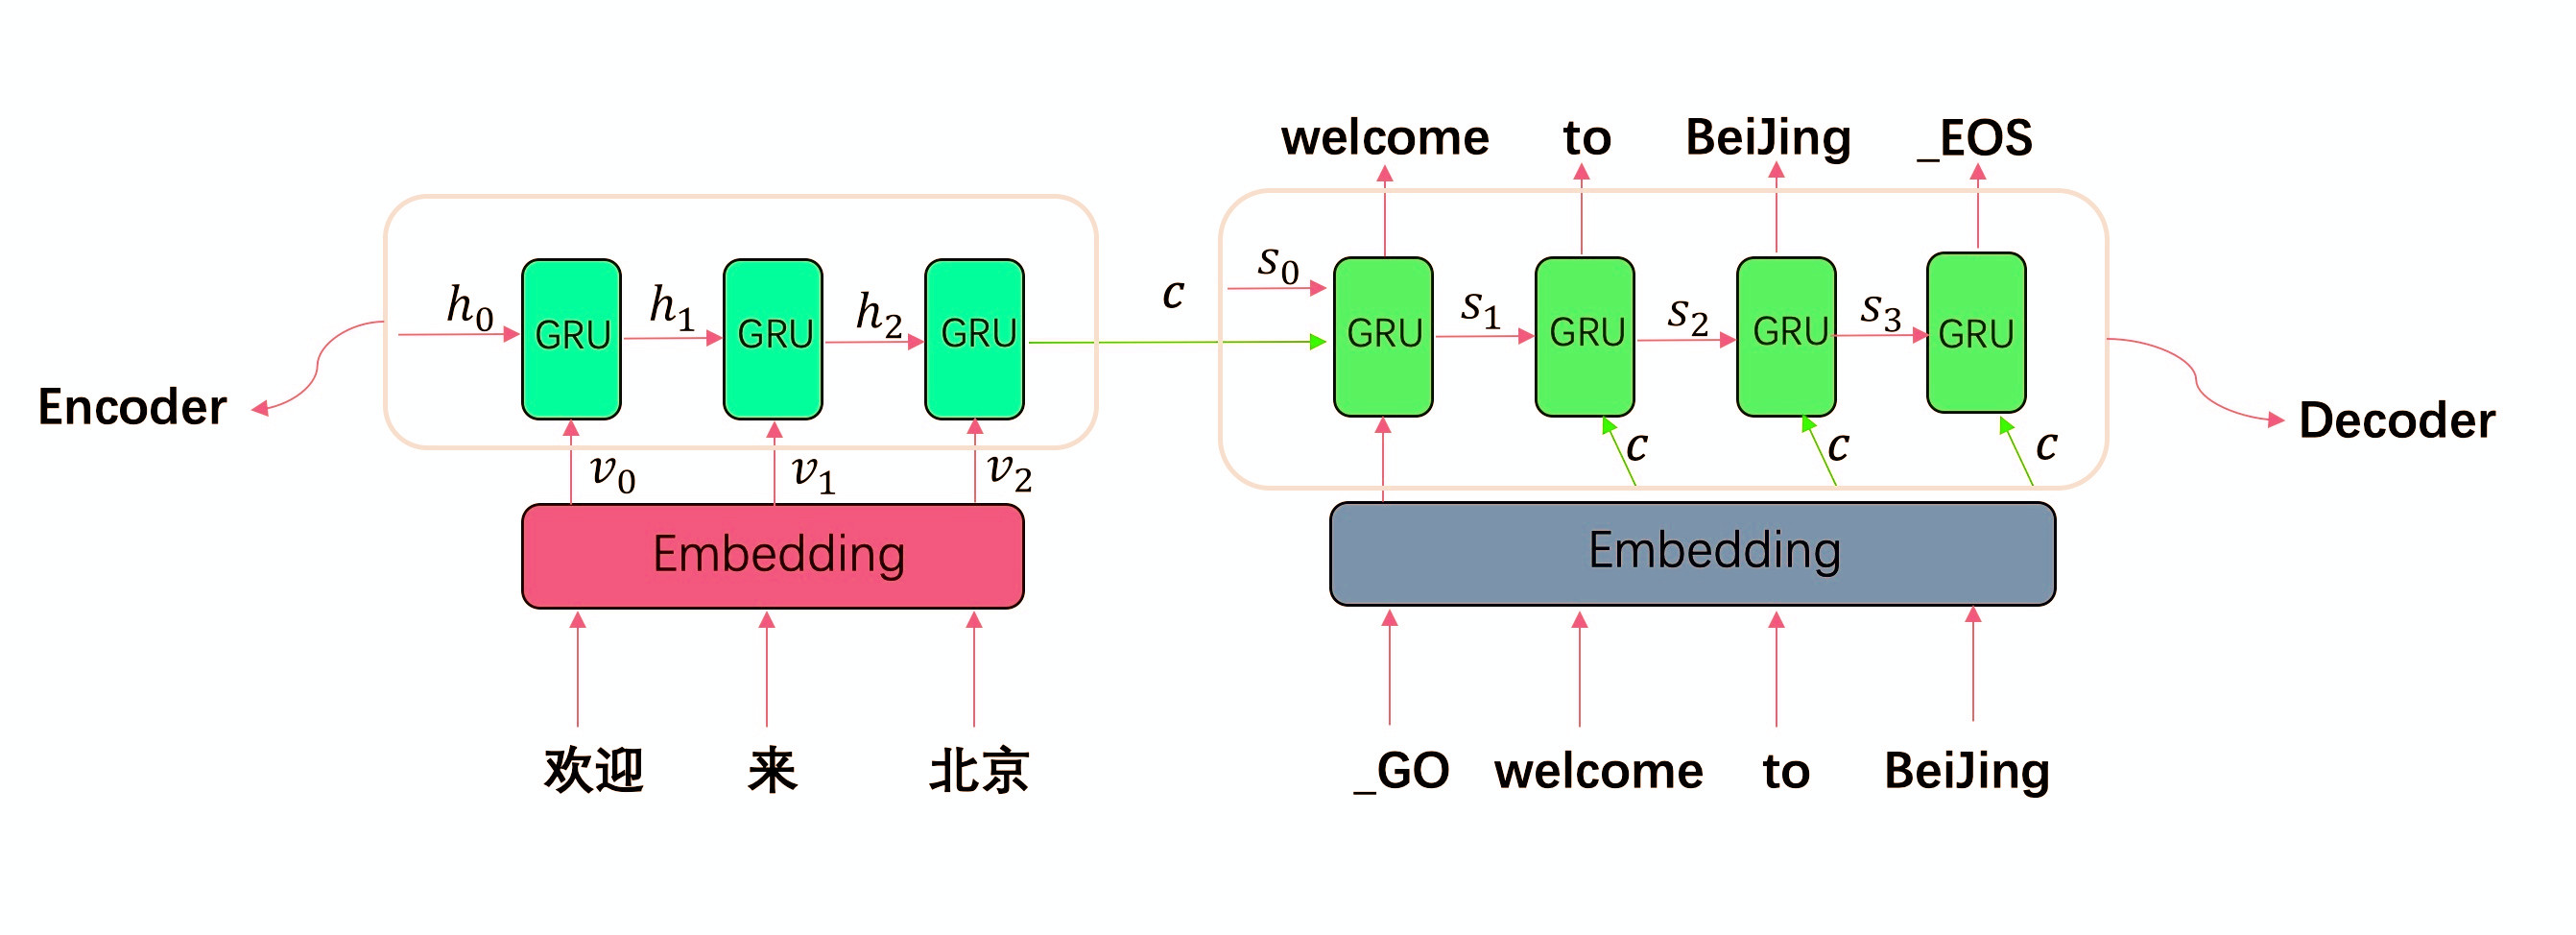

## 2.3 Seq2seq实战：单词序-->字母序

# 3. Seq2Seq+Attention

## 3.1 Seq2Seq思考

- Encoder将输入编码为固定大小状态向量，是一个”信息有损压缩“的过程， 信息量越大，那么损失的信息就越多。
- 随着sequence length的增加，意味着时间维度上的序列很长，RNN模型 会出现梯度弥散。
- 基础的模型连接Encoder和Decoder模块的组件仅仅是一个固定大小的状态向量，Decoder无法直接去关注到输入信息的更多细节。

## 3.2 什么叫注意力机制

注意到Decoder设计中，各个时刻都使用相同的记忆C，我们自然想到了可以在不同的时刻采用不同的记忆C，结构如下：

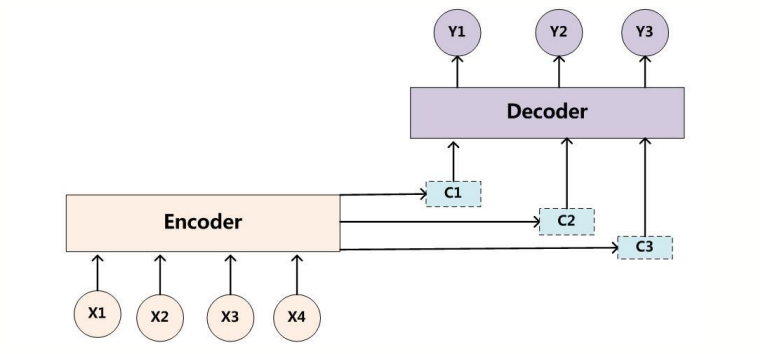

## 3.3 模型细节

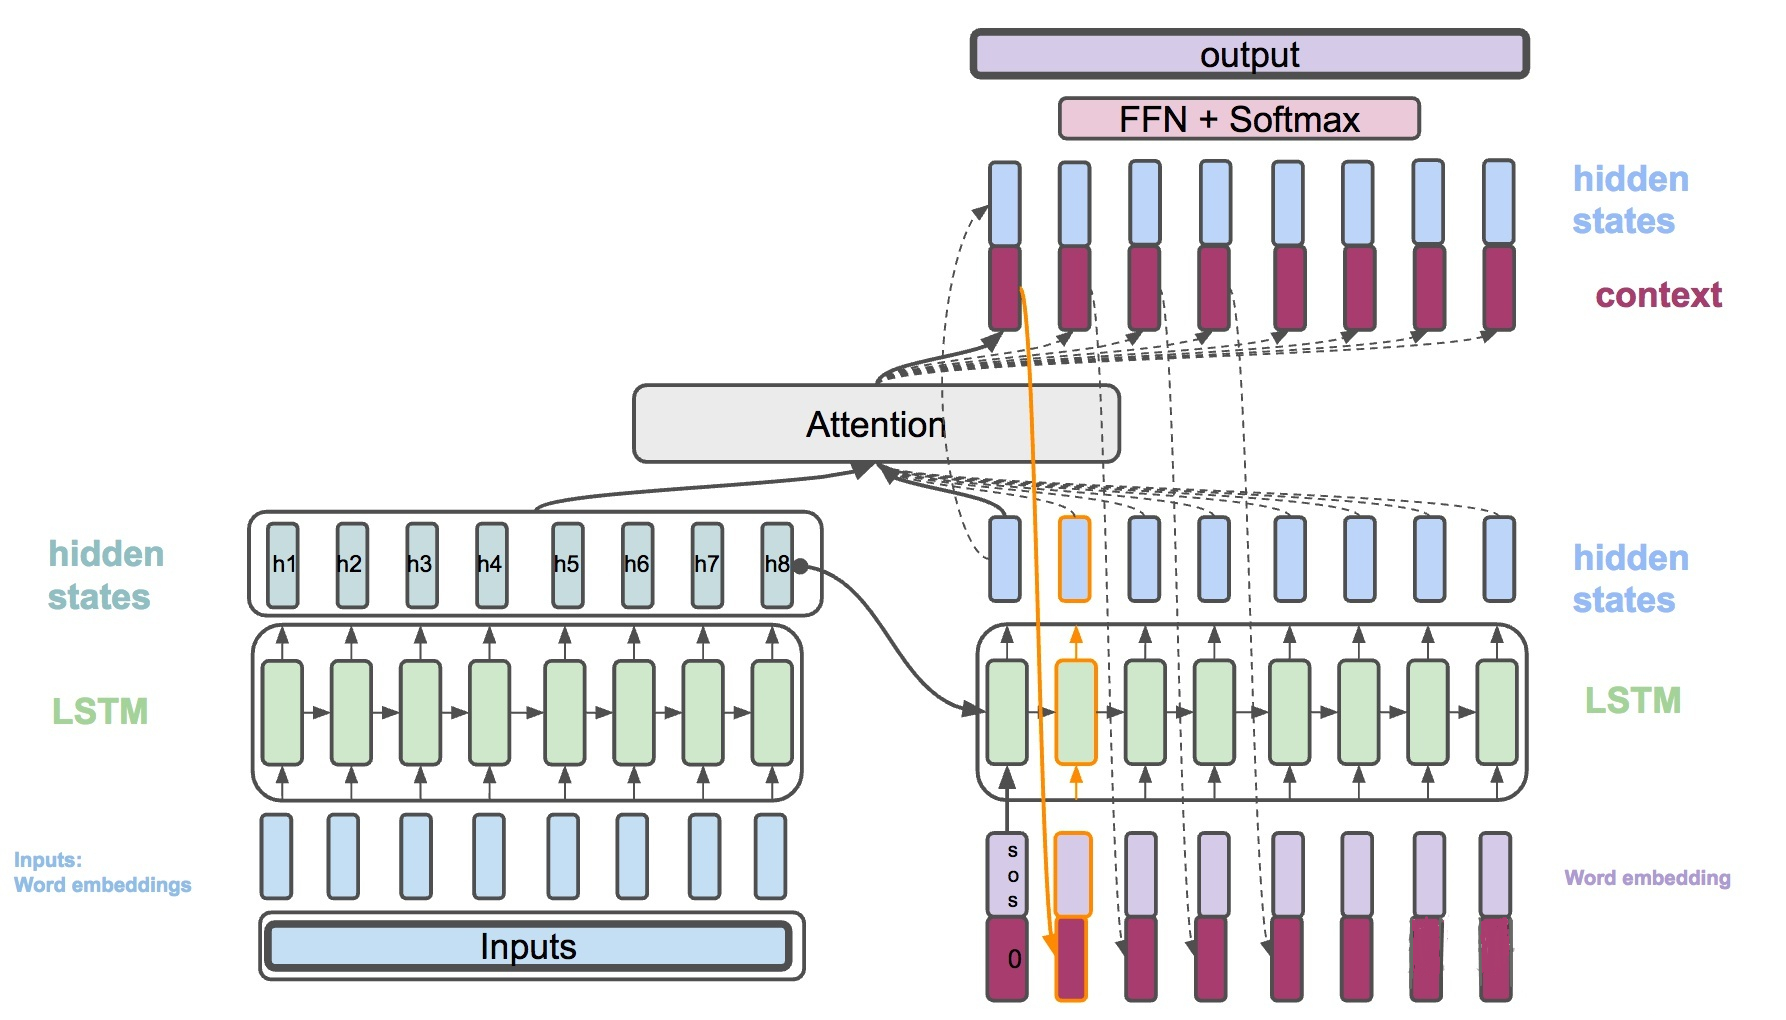

输入：$x = \left( x _ { 1 } , \dots , x _ { T _ { x } } \right)$

输出：$y = \left( y _ { 1 } , \ldots , y _ { T _ { y } } \right)$

（1）$h _ { t } = R N N _ { e n c } \left( x _ { t } , h _ { t - 1 } \right)$、

   Encoder方面接受的是每一个单词word embedding，和上一个时间点的hidden state。输出的是这个时间点的hidden state。

（2）$s _ { t } = R N N _ { d e c } \left( y _ { t - 1 } ^ { \wedge } , s _ { t - 1 } \right)$

Decoder方面接受的是目标句子里单词的word embedding，和上一个时间点的hidden state。

（3）$c _ { i } = \sum _ { j = 1 } ^ { T _ { x } } \alpha _ { i j } h _ { j }$

 context vector是一个对于encoder输出的hidden states的一个加权平均。

（4）$\alpha _ { i j } = \frac { \exp \left( e _ { i j } \right) } { \sum _ { k = 1 } ^ { T _ { x } } \exp \left( e _ { i k } \right) }$

每一个encoder的hidden states对应的权重

(5) $e _ { i j } = \operatorname { score } \left( s _ { i } , h _ { j } \right)$

通过decoder的hidden states加上encoder的hidden states来计算一个分数，用于计算权重(4)

(6)$\hat { s } _ { t } = \tanh \left( W _ { c } \left[ c _ { t } ; s _ { t } \right] \right)$

将context vector 和 decoder的hidden states 串起来

(7)$p \left( y _ { t } | y _ { < t } , x \right) = \operatorname { softmax } \left( W _ { s } \hat { s } _ { t } \right)$

计算最后的输出概率